In [83]:
import yfinance as yf
from datetime import datetime, timedelta, timezone
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
import seaborn as sns
from tqdm import tqdm
import pandas as pd
from statsmodels.tools.sm_exceptions import ValueWarning, HessianInversionWarning, ConvergenceWarning
import warnings
from time import time
from sklearn.metrics import mean_squared_error


#in practice do not supress these warnings, they carry important information about the status of your model
warnings.filterwarnings('ignore', category=ValueWarning)
warnings.filterwarnings('ignore', category=HessianInversionWarning)
warnings.filterwarnings('ignore', category=ConvergenceWarning)
warnings.filterwarnings('ignore', category=UserWarning)

# Rolling

In [84]:
def rolling(p, q):
  #create the model
  predictions_rolling = pd.Series()
  for end_date in test_data.index:
      train_data_R = prices[crypto][timeFrames.index(tF)][:end_date - timedelta(days=1)]
      model = ARIMA(train_data_R, order=(p,0,q))
      model_fit = model.fit()
      pred = model_fit.predict(end_date)
      predictions_rolling.loc[end_date]=pred.loc[end_date]

  residuals_rolling = test_data - predictions_rolling
  plt.figure(figsize=(10,4))

  plt.plot(test_data)
  plt.plot(predictions_rolling)
  plt.legend(('Data','Predictions'), fontsize=16)


# Read Data

In [85]:
cryptos = ['BTC-USD', 'ETH-USD', 'USDT-USD', 'BNB-USD', 'XRP-USD']
timeFrames = ['1mo', '1d']

start_date = datetime(2022,11,1, tzinfo=timezone.utc)
end_date = datetime(2023,11,1, tzinfo=timezone.utc)


In [86]:
prices = {}
returns = {}


for crypto in cryptos:
    ticker = yf.Ticker(crypto)
    prices_1mo = ticker.history(start=start_date, end=end_date, interval=timeFrames[0]).Close
    returns_1mo = prices_1mo.pct_change().dropna()

    prices_1d = ticker.history(start=start_date, end=end_date, interval=timeFrames[1]).Close
    returns_1d = prices_1d.pct_change().dropna()

    if crypto not in prices:
        prices[crypto] = []
        returns[crypto] = []

    prices[crypto].append(prices_1mo)
    returns[crypto].append(returns_1mo)

    prices[crypto].append(prices_1d)
    returns[crypto].append(returns_1d)




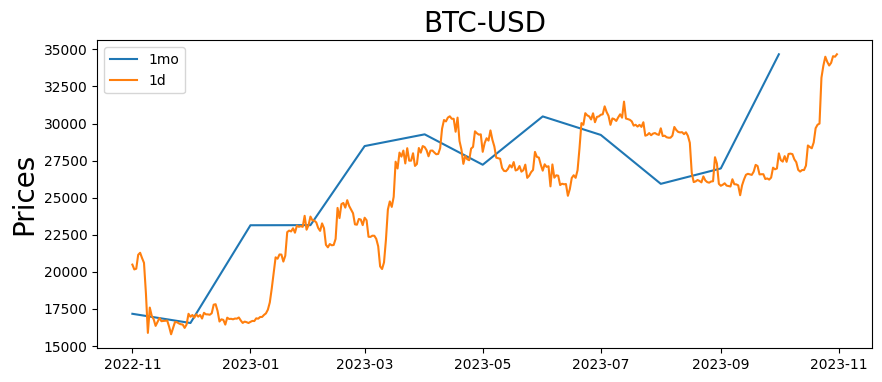

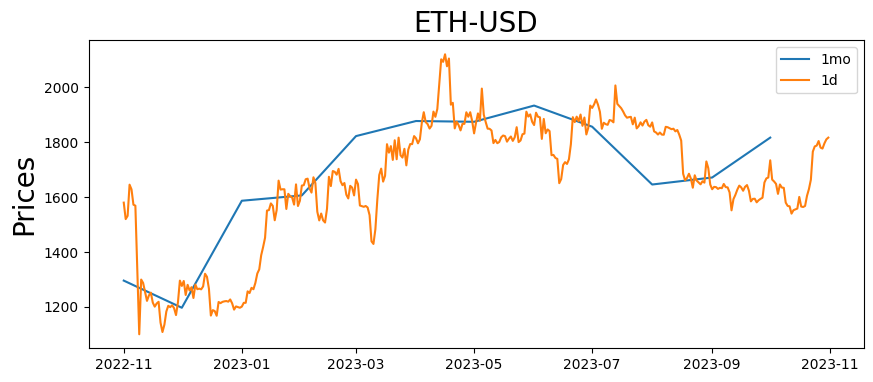

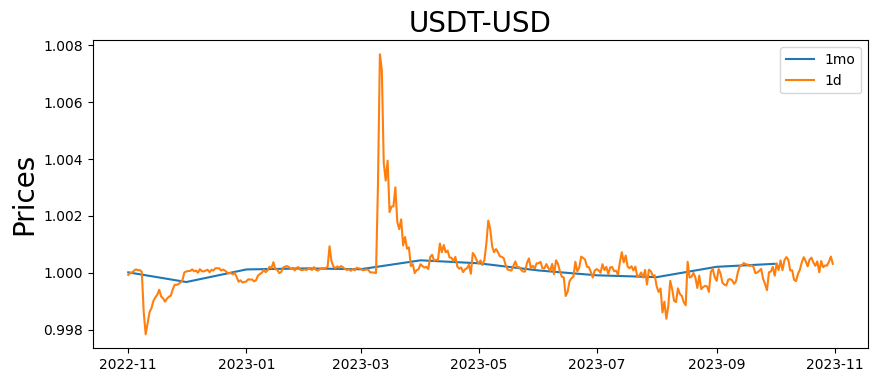

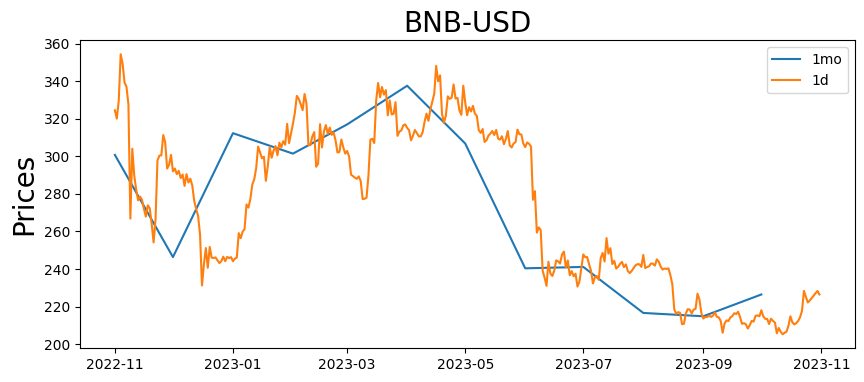

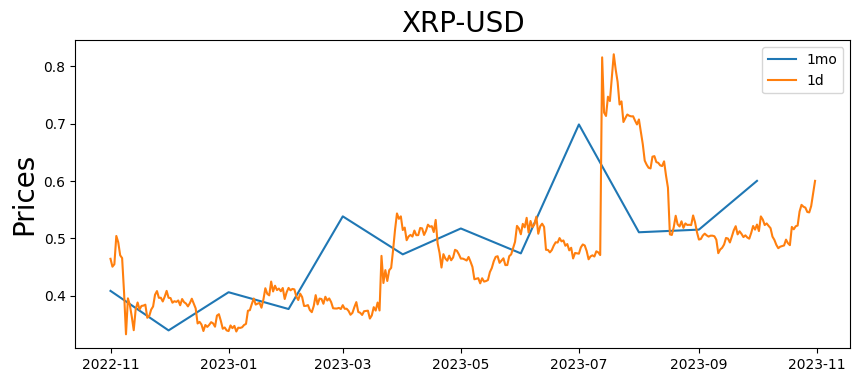

In [87]:
for crypto in cryptos:
    plt.figure(figsize=(10,4))
    for i, tF in enumerate(timeFrames):
        plt.plot(prices[crypto][i], label=f"{tF}")
    plt.title(f"{crypto}", fontsize=20)
    plt.ylabel('Prices', fontsize=20)
    plt.legend()
    plt.show()


## ACF

In [89]:
p_values = {}

for crypto in cryptos:
  for i, tF in enumerate(timeFrames):
    result = adfuller(prices[crypto][i])
    print(f"crypto: {crypto}, result[1]: {result[1]}, tF: {tF}")
    p_value = result[1]
    if p_value <= 0.1:
      p_values[f"{crypto}, {tF}"] = p_value

crypto: BTC-USD, result[1]: 0.24637004959145098, tF: 1mo
crypto: BTC-USD, result[1]: 0.8847855278596932, tF: 1d
crypto: ETH-USD, result[1]: 0.004095915279189181, tF: 1mo
crypto: ETH-USD, result[1]: 0.4338634428412075, tF: 1d
crypto: USDT-USD, result[1]: 0.139401124798061, tF: 1mo
crypto: USDT-USD, result[1]: 0.0019003353971645154, tF: 1d
crypto: BNB-USD, result[1]: 0.664351676000936, tF: 1mo
crypto: BNB-USD, result[1]: 0.38330053826784727, tF: 1d
crypto: XRP-USD, result[1]: 0.3483824579098429, tF: 1mo
crypto: XRP-USD, result[1]: 0.37503245177282124, tF: 1d


In [90]:
min_p_value_crypto = min(p_values, key=p_values.get)
print(f'The cryptocurrency with the smallest p-value is {min_p_value_crypto} with a p-value of {p_values[min_p_value_crypto]}')

The cryptocurrency with the smallest p-value is USDT-USD, 1d with a p-value of 0.0019003353971645154


In [91]:
crypto, tF = min_p_value_crypto.split(',')
tF = tF.replace(" ", "")
bestAmountOfPvalue = prices[crypto][timeFrames.index(tF)]

# Q2

## ACF

('USDT-USD', 1)

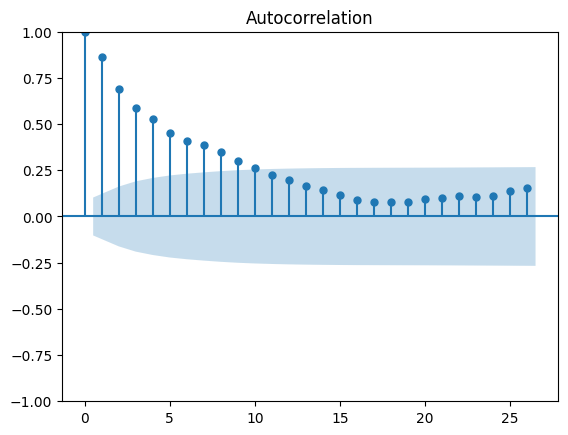

In [92]:
acf_plot = plot_acf(bestAmountOfPvalue)
crypto, timeFrames.index(tF)

## PACF

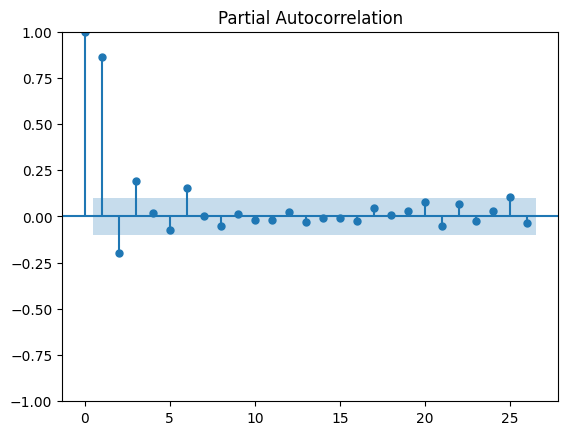

In [93]:
pacf_plot = plot_pacf(bestAmountOfPvalue)

### AR

In [94]:
model = ARIMA(bestAmountOfPvalue, order=(1,0,0))

In [95]:
start = time()
model_fit = model.fit()
end = time()
print('Model fitting time is: ', end-start)

Model fitting time is:  0.33434128761291504


In [96]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  365
Model:                 ARIMA(1, 0, 0)   Log Likelihood                2311.256
Date:                Thu, 14 Dec 2023   AIC                          -4616.512
Time:                        14:17:43   BIC                          -4604.812
Sample:                    11-01-2022   HQIC                         -4611.862
                         - 10-31-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0002      0.000   4157.765      0.000       1.000       1.001
ar.L1          0.8611      0.010     85.094      0.000       0.841       0.881
sigma2      1.842e-07   3.15e-09     58.549      0.0

### MA

In [97]:
model = ARIMA(prices[crypto][timeFrames.index(tF)], order=(0,0,3))

In [98]:
start = time()
model_fit = model.fit()
end = time()
print('Model fitting time is: ', end-start)

Model fitting time is:  0.6195120811462402


In [99]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  365
Model:                 ARIMA(0, 0, 3)   Log Likelihood                2257.856
Date:                Thu, 14 Dec 2023   AIC                          -4505.713
Time:                        14:17:43   BIC                          -4486.213
Sample:                    11-01-2022   HQIC                         -4497.963
                         - 10-31-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0002      0.000   8956.993      0.000       1.000       1.000
ma.L1          1.0737      0.017     62.862      0.000       1.040       1.107
ma.L2          0.7826      0.019     42.102      0.0

### ARMA

In [100]:
model = ARIMA(prices[crypto][timeFrames.index(tF)], order=(1,0,3))

In [101]:
start = time()
model_fit = model.fit()
end = time()
print('Model fitting time is: ', end-start)

Model fitting time is:  0.307051420211792


In [102]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  365
Model:                 ARIMA(1, 0, 3)   Log Likelihood                2327.320
Date:                Thu, 14 Dec 2023   AIC                          -4642.640
Time:                        14:17:44   BIC                          -4619.241
Sample:                    11-01-2022   HQIC                         -4633.341
                         - 10-31-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0002      0.000   4285.399      0.000       1.000       1.001
ar.L1          0.8928      0.026     34.401      0.000       0.842       0.944
ma.L1          0.1858      0.036      5.135      0.0

## Test

In [103]:
train_start = '2022-11-01'
train_end = '2023-09-30'
test_start = '2023-10-01'
test_end = '2023-11-01'

In [104]:
train_end = datetime(2023,9,30, tzinfo=timezone.utc)
test_end = datetime(2023,11,1, tzinfo=timezone.utc)

train_data = prices[crypto][timeFrames.index(tF)].loc[:train_end][:]
test_data = prices[crypto][timeFrames.index(tF)].loc[train_end + timedelta(days=1):test_end]
print(train_end)
print(test_end)

2023-09-30 00:00:00+00:00
2023-11-01 00:00:00+00:00


## AR

In [105]:
model = ARIMA(train_data, order=(1,0,0))

In [106]:
start = time()
model_fit = model.fit()
end = time()
print('Model fitting time is: ', end-start)

Model fitting time is:  0.1866466999053955


In [107]:
pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]
test_data.index[-1]

Timestamp('2023-10-31 00:00:00+0000', tz='UTC')

In [108]:
predictions = model_fit.predict(start=pred_start_date, end=pred_end_date)
residuals = test_data - predictions

## Plot

Text(0, 0.5, 'Production')

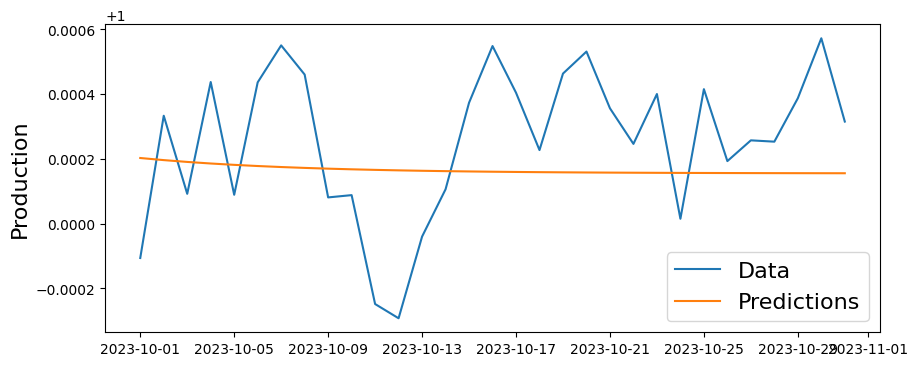

In [109]:
plt.figure(figsize=(10,4))

plt.plot(test_data)
plt.plot(predictions)
plt.legend(('Data','Predictions'), fontsize=16)
plt.ylabel('Production', fontsize=16)

<ipython-input-84-17bbaa34c054>:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  predictions_rolling = pd.Series()


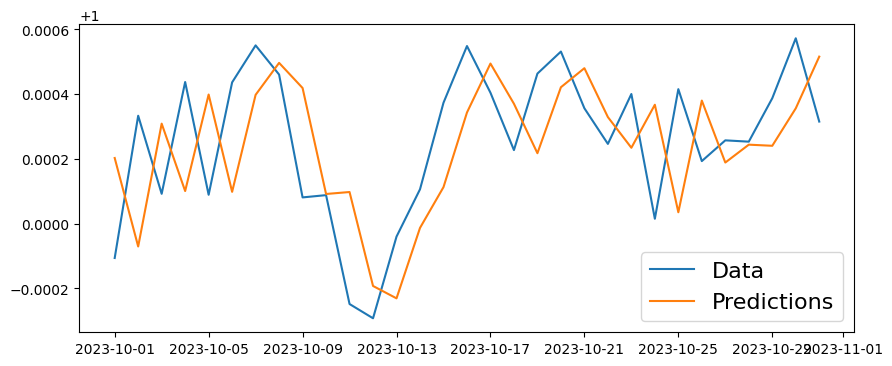

In [110]:
rolling(1, 0)

### MAPE

In [111]:
print('Mean absolute percent error (MAPE):', np.mean(abs(residuals/test_data)))

Mean absolute percent error (MAPE): 0.00021509993688424687


### MSE

In [112]:
print('Mean Squared Error (MSE):', np.mean(residuals**2))

Mean Squared Error (MSE): 6.072486496603657e-08


# MA

In [113]:
model = ARIMA(train_data, order=(0,0,3))

In [114]:
start = time()
model_fit_predict = model.fit()
end = time()
print('Model fitting time is: ', end-start)

Model fitting time is:  0.4327726364135742


In [115]:
predictions = model_fit_predict.predict(start=pred_start_date, end=pred_end_date)
residuals = test_data - predictions

Text(0, 0.5, 'Production')

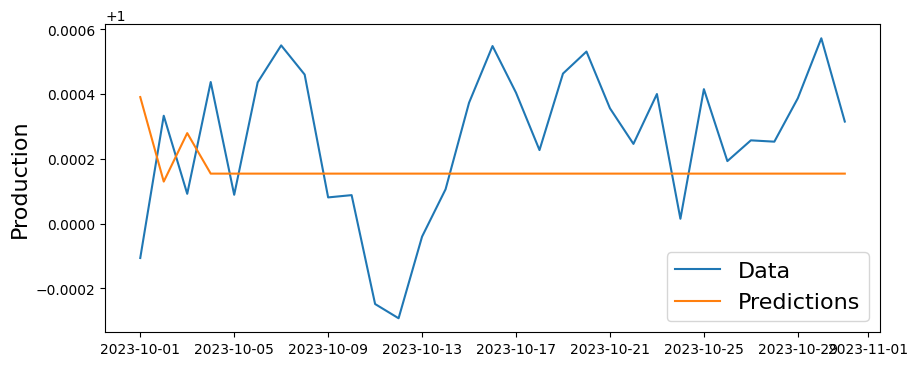

In [116]:
plt.figure(figsize=(10,4))

plt.plot(test_data)
plt.plot(predictions)
plt.legend(('Data','Predictions'), fontsize=16)
plt.ylabel('Production', fontsize=16)

<ipython-input-84-17bbaa34c054>:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  predictions_rolling = pd.Series()


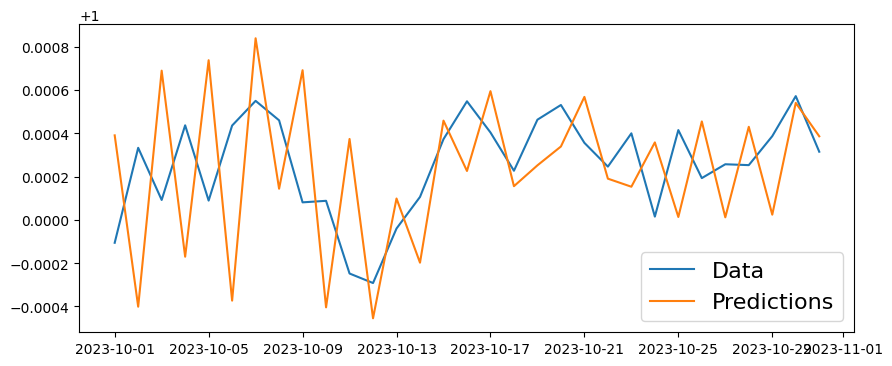

In [117]:
rolling(0, 3)

### MAPE

In [118]:
print('Mean absolute percent error (MAPE):', np.mean(abs(residuals/test_data)))

Mean absolute percent error (MAPE): 0.00022763869163227096


### MSE

In [119]:
print('Mean Squared Error (MSE):', np.mean(residuals**2))

Mean Squared Error (MSE): 6.863598464636257e-08


# ARMA

In [120]:
model = ARIMA(train_data, order=(1,0,3))

In [121]:
start = time()
model_fit_predict = model.fit()
end = time()
print('Model fitting time is: ', end-start)

Model fitting time is:  0.6269478797912598


In [122]:
predictions = model_fit_predict.predict(start=pred_start_date, end=pred_end_date)
residuals = test_data - predictions

Text(0, 0.5, 'Production')

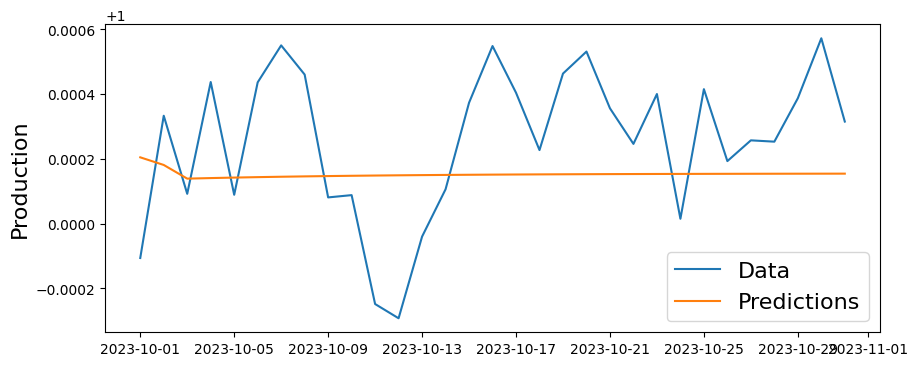

In [123]:
plt.figure(figsize=(10,4))
plt.plot(test_data)
plt.plot(predictions)
plt.legend(('Data','Predictions'), fontsize=16)
plt.ylabel('Production', fontsize=16)

<ipython-input-84-17bbaa34c054>:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  predictions_rolling = pd.Series()


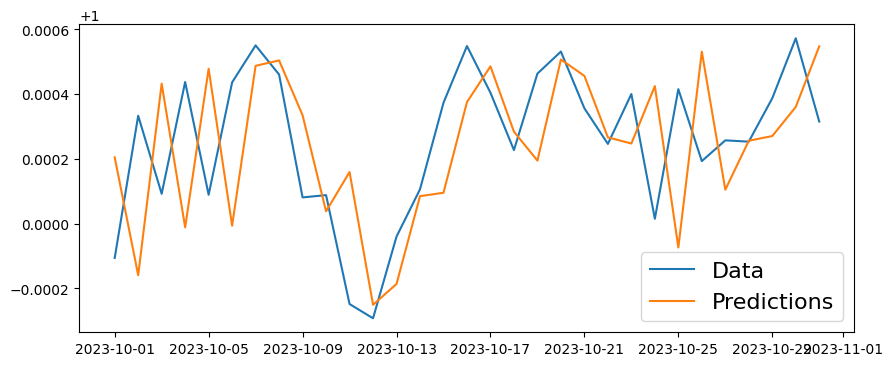

In [124]:
rolling(1, 3)

### MAPE

In [125]:
print('Mean absolute percent error (MAPE):', np.mean(abs(residuals/test_data)))

Mean absolute percent error (MAPE): 0.00021602185511825452


### MSE

In [126]:
print('Mean Squared Error (MSE):', np.mean(residuals**2))

Mean Squared Error (MSE): 6.287599006872623e-08


# Q3

In [127]:
def ar_model(p):
  model = ARIMA(train_data, order=(p,0,0))
  model_fit_predict = model.fit()
  predictions = model_fit_predict.predict(start=pred_start_date, end=pred_end_date)
  residuals = test_data - predictions
  return residuals

In [128]:
def ma_model(q):
  model = ARIMA(train_data, order=(0,0,q))
  model_fit_predict = model.fit()
  predictions = model_fit_predict.predict(start=pred_start_date, end=pred_end_date)
  residuals = test_data - predictions
  return residuals

In [129]:
def arma_model(p, q):
  model = ARIMA(train_data, order=(p,0,q))
  model_fit_predict = model.fit()
  predictions = model_fit_predict.predict(start=pred_start_date, end=pred_end_date)
  residuals = test_data - predictions
  return residuals

In [130]:
B_p = [0, 0, 0]
B_q = [0, 0, 0]
B_MAPE = [1, 1, 1]
B_MSE = [1, 1, 1]
B_res = []

for p in range(1, 16):
  print(f"p: {p}")
  for q in range(1, 16):
    residuals = [ar_model(p), ma_model(q), arma_model(p, q)]
    for i, res in enumerate(residuals):
      MAPE = np.mean(abs(res/test_data))
      MSE = np.mean(res**2)
      if MAPE < B_MAPE[i] and MSE < B_MSE[i]:
        B_MAPE[i] = MAPE
        B_MSE[i] = MSE
        if i == 0:
          B_p[i] = p
          B_q[i] = 0
        elif i == 1:
          B_q[i] = q
          B_p[i] = 0
        else:
          B_p[i] = p
          B_q[i] = q
        print(f"Best p: {B_p}, Best q: {B_q}, B_MAPE[i]: {B_MAPE[i]}, B_MSE[i]: {B_MSE[i]}")

p: 1
Best p: [1, 0, 0], Best q: [0, 0, 0], B_MAPE[i]: 0.00021509993688424687, B_MSE[i]: 6.072486496603657e-08
Best p: [1, 0, 0], Best q: [0, 1, 0], B_MAPE[i]: 0.00021667919031058208, B_MSE[i]: 6.243011003847472e-08
Best p: [1, 0, 1], Best q: [0, 1, 1], B_MAPE[i]: 0.0002162349645145755, B_MSE[i]: 6.148365921188252e-08
Best p: [1, 0, 1], Best q: [0, 2, 1], B_MAPE[i]: 0.0002095498439821032, B_MSE[i]: 5.952225042148148e-08
Best p: [1, 0, 1], Best q: [0, 2, 4], B_MAPE[i]: 0.00021317106224353152, B_MSE[i]: 6.038494271314238e-08
Best p: [1, 0, 1], Best q: [0, 6, 4], B_MAPE[i]: 0.00020826040053448263, B_MSE[i]: 5.9218640645612476e-08
Best p: [1, 0, 1], Best q: [0, 8, 4], B_MAPE[i]: 0.0002064360716628369, B_MSE[i]: 5.796441218407212e-08
Best p: [1, 0, 1], Best q: [0, 10, 4], B_MAPE[i]: 0.00020583432504083069, B_MSE[i]: 5.708712843912922e-08
p: 2
Best p: [1, 0, 2], Best q: [0, 10, 1], B_MAPE[i]: 0.00021006163740677032, B_MSE[i]: 6.011322168013393e-08
p: 3
p: 4
Best p: [1, 0, 4], Best q: [0, 10, 

In [131]:
print(f"Best p: {B_p}, Best q: {B_q}")
for i in range(3):
  print(f"B_MAPE[i]: {B_MAPE[i]}, B_MSE[i]: {B_MSE[i]}, B_p: {B_p[i]}, B_q: {B_q[i]}")

Best p: [5, 0, 9], Best q: [0, 10, 11]
B_MAPE[i]: 0.00021495818080776485, B_MSE[i]: 6.033112318708502e-08, B_p: 5, B_q: 0
B_MAPE[i]: 0.00020583432504083069, B_MSE[i]: 5.708712843912922e-08, B_p: 0, B_q: 10
B_MAPE[i]: 0.0001853195455084196, B_MSE[i]: 5.1861016827461545e-08, B_p: 9, B_q: 11


### AR

In [132]:
model = ARIMA(train_data, order=(B_p[0],0,B_q[0]))
model_fit_predict = model.fit()
predictions = model_fit_predict.predict(start=pred_start_date, end=pred_end_date)
residuals = test_data - predictions

Text(0, 0.5, 'Production')

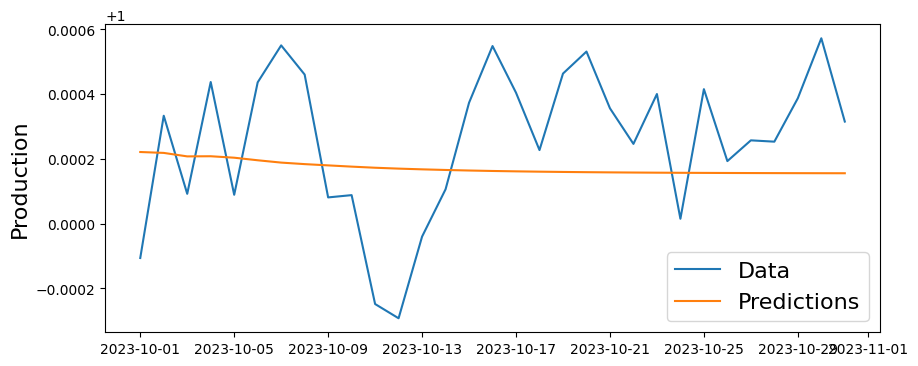

In [133]:
plt.figure(figsize=(10,4))

plt.plot(test_data)
plt.plot(predictions)

plt.legend(('Data','Predictions'), fontsize=16)
plt.ylabel('Production', fontsize=16)


<ipython-input-84-17bbaa34c054>:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  predictions_rolling = pd.Series()


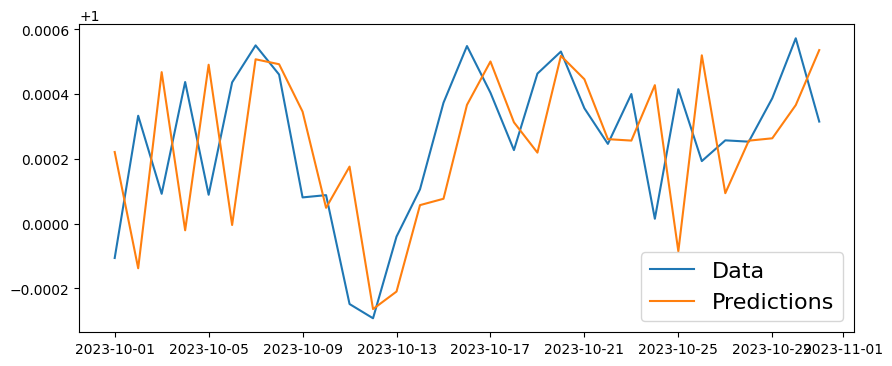

In [134]:
rolling(B_p[0], B_q[0])

### MA

In [135]:
model = ARIMA(train_data, order=(B_p[1],0,B_q[1]))
model_fit_predict = model.fit()
predictions = model_fit_predict.predict(start=pred_start_date, end=pred_end_date)
residuals = test_data - predictions

Text(0, 0.5, 'Production')

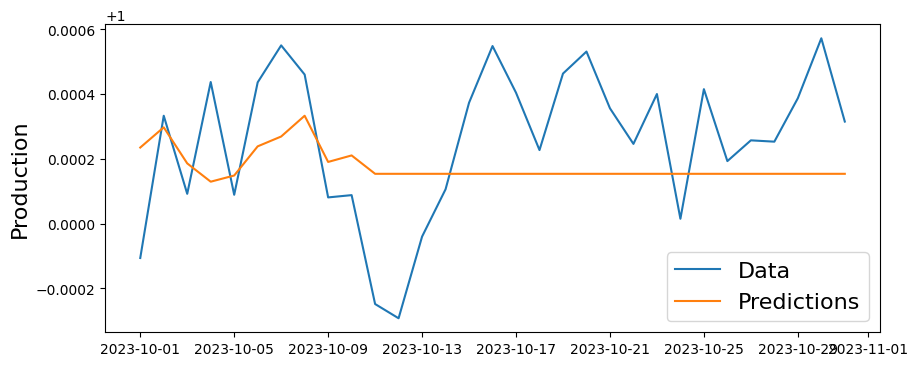

In [136]:
plt.figure(figsize=(10,4))

plt.plot(test_data)
plt.plot(predictions)

plt.legend(('Data','Predictions'), fontsize=16)
plt.ylabel('Production', fontsize=16)


<ipython-input-84-17bbaa34c054>:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  predictions_rolling = pd.Series()


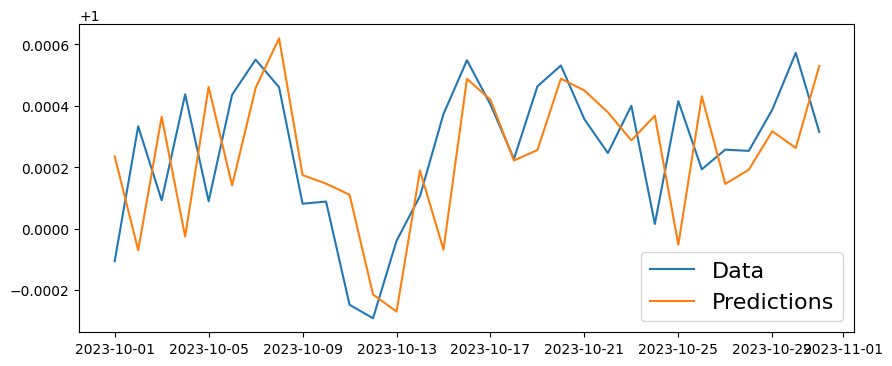

In [137]:
rolling(B_p[1], B_q[1])

### ARMA

In [138]:
model = ARIMA(train_data, order=(B_p[2],0,B_q[2]))
model_fit_predict = model.fit()
predictions = model_fit_predict.predict(start=pred_start_date, end=pred_end_date)
residuals = test_data - predictions

Text(0, 0.5, 'Production')

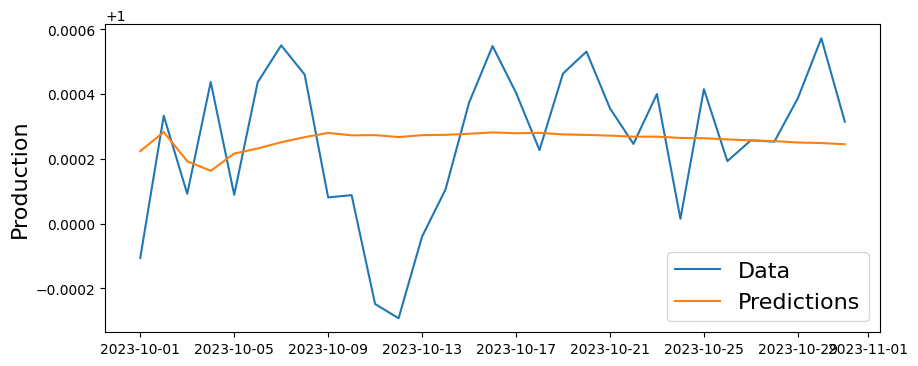

In [139]:
plt.figure(figsize=(10,4))

plt.plot(test_data)
plt.plot(predictions)

plt.legend(('Data','Predictions'), fontsize=16)
plt.ylabel('Production', fontsize=16)


<ipython-input-84-17bbaa34c054>:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  predictions_rolling = pd.Series()


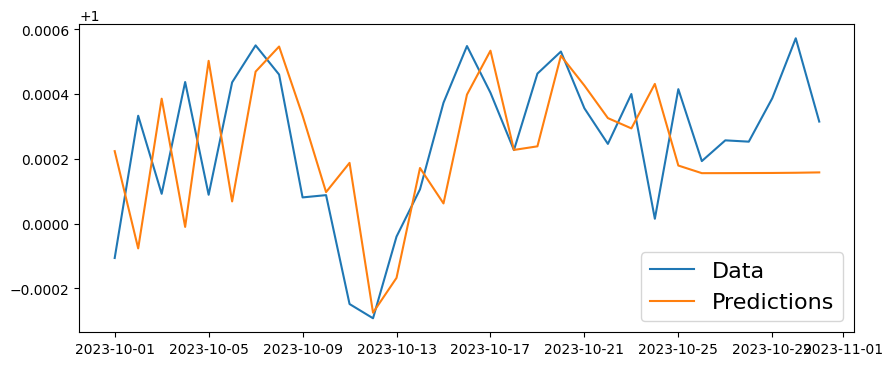

In [140]:
rolling(B_p[2], B_q[2])

In [141]:
print(f"for AR:")
print(f"MSE: {B_MSE[0]}")
print(f"MAPE: {B_MAPE[0]}\n")

print(f"for MA:")
print(f"MSE: {B_MSE[1]}")
print(f"MAPE: {B_MAPE[1]}\n")

print(f"for ARMA:")
print(f"MSE: {B_MSE[2]}")
print(f"MAPE: {B_MAPE[2]}")

for AR:
MSE: 6.033112318708502e-08
MAPE: 0.00021495818080776485

for MA:
MSE: 5.708712843912922e-08
MAPE: 0.00020583432504083069

for ARMA:
MSE: 5.1861016827461545e-08
MAPE: 0.0001853195455084196
